In [1]:
# Libraries
#!pip install fastai --upgrade
from fastai.vision.all import * # for computer vision models
from fastai.text.all import * # for text
from fastai.tabular.all import * # for tabular
from fastai.collab import * 

import numpy as np
import pandas as pd

# !pip install ipywidgets
from ipywidgets import * # to upload image

## Image Classification: cnn_learner

Usecase: a model that classify images based on given label function

In [2]:
path = untar_data(URLs.PETS)/'images'

def is_dog(x): 
    return x[0].islower()

# indicate what type of dataset, label, and labeling methods to fastai
dls = ImageDataLoaders.from_name_func(path, get_image_files(path), valid_pct=0.2, seed=42, label_func=is_dog, item_tfms=Resize(224))

# the pretrained CNN model using the architecture of ResNet with 34 layers
learn = cnn_learner(dls, resnet34, metrics=error_rate) 
learn.fine_tune(1)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


epoch,train_loss,valid_loss,error_rate,time
0,0.141263,0.013357,0.004736,00:47


epoch,train_loss,valid_loss,error_rate,time
0,0.049305,0.011533,0.003383,00:49


Testing model on a puppy

In [ ]:
uploader = widgets.FileUpload()
uploader

FileUpload(value={}, description='Upload')

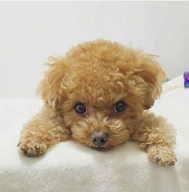

In [ ]:
# Image source: puppygr4m on Instagram
img = PILImage.create(uploader.data[0])
img.to_thumb(192)

In [ ]:
img = PILImage.create(uploader.data[0])
is_dog, _ , probs = learn.predict(img)
print(f"Is this a dog?: {is_dog}.")
print(f"Probability it's a dog: {probs[1].item():.6f}")

Is this a dog?: True.
Probability it's a dog: 1.000000


Testing model on a kitten

In [ ]:
uploader

FileUpload(value={}, description='Upload')

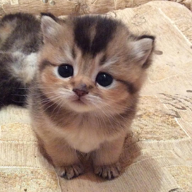

In [ ]:
# Image source: Ney Pereira on Pinterest
img = PILImage.create(uploader.data[0])
img.to_thumb(192)

In [ ]:
is_dog, _ , probs = learn.predict(img)
print(f"Is this a dog?: {is_dog}.")
print(f"Probability it's a dog: {probs[1].item():.6f}")

Is this a dog?: False.
Probability it's a dog: 0.000030


## Segmentation: unet_learner

Usecase: a model that recognizes contents inside an image by color-coding every pixel by it's classification

In [4]:
path = untar_data(URLs.CAMVID_TINY)
dls = SegmentationDataLoaders.from_label_func(
    path, bs=8, fnames = get_image_files(path/"images"),
    label_func = lambda o: path/'labels'/f'{o.stem}_P{o.suffix}',
    codes = np.loadtxt(path/'codes.txt', dtype=str))

learn = unet_learner(dls, resnet34)
learn.fine_tune(8)

epoch,train_loss,valid_loss,time
0,2.887064,2.151191,00:03


epoch,train_loss,valid_loss,time
0,1.593554,1.334139,00:01
1,1.439653,1.245774,00:01
2,1.434775,1.254532,00:01
3,1.331274,1.083013,00:01
4,1.230147,1.018600,00:01
5,1.123843,0.922202,00:01
6,1.029636,0.839998,00:01
7,0.954436,0.844251,00:01


In [5]:
# Upload San Francisco city image
uploader = widgets.FileUpload()
uploader

FileUpload(value={}, description='Upload')

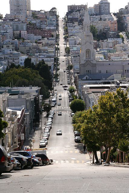

In [31]:
# Image Source: MT_80, https://www.flickr.com/photos/mt_80/2942929286/ 
img = PILImage.create(uploader.data[0])
img.to_thumb(193)

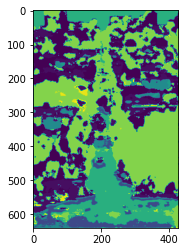

In [32]:
p,img_hr,b = learn.predict(img) # Using unet_model to create a color-coded image
plt.imshow(img_hr)

## Sentiment Analysis: text_classifier_learner

Usecase: a model that classifies reviews by positive or negative

In [17]:
# Using IMDB_SAMPLE instead of IMDB for faster training
path = untar_data(URLs.IMDB_SAMPLE)
df = pd.read_csv(path/"texts.csv"); df.head()
dls = TextDataLoaders.from_df(df, path=path, text_col='text', label_col='label', valid_col='is_valid')
learn_text = text_classifier_learner(dls, AWD_LSTM, drop_mult=0.5, metrics=accuracy)
learn_text.fine_tune(4)

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


epoch,train_loss,valid_loss,accuracy,time
0,0.671432,0.668034,0.565000,00:05


epoch,train_loss,valid_loss,accuracy,time
0,0.471119,0.639970,0.610000,00:12
1,0.434046,0.571300,0.685000,00:12
2,0.391044,0.552588,0.700000,00:12
3,0.359833,0.548246,0.730000,00:13


In [15]:
# To look at the path of the data sample
path.ls()

(#1) [Path('/root/.fastai/data/imdb_sample/texts.csv')]

In [23]:
learn_text.predict('It was okay. Not the best nor the worst')

('positive', tensor(1), tensor([0.0987, 0.9013]))

Model considered the review to be negative.

In [24]:
# Testing model on a 1-star yelp review
yelp_review = "Called in an order at 5:15PM and was quoted a 45 minute wait. Got to the restaurant at 5:55PM expecting our order to be nearly ready. When we arrived, we were completely surprised by the line down the block. Workers in the restaurant were calling out the last 4 of your number IF your order was ready. Ended up waiting in line for 20 minutes to be told our order would be 10 minutes more. Waited another half an hour and our food was still not ready. Ridiculous! No restaurant is that good to wait over an hour and a half for take out. Workers need to learn to quote more accurate times and not use the excuse 'so busy.' Would give no stars if possible."
learn_text.predict(yelp_review)

('negative', tensor(0), tensor([0.6326, 0.3674]))

Model considered the review to be positive even though the user gave the restaurant a 1-star review.

## Decision Tree: tabular_learner

*tabular = data in the form of a table/spreadsheet/database/csv file*

Usecase: a model that predict one column of a table based on information in other columns of the table

In [6]:
path = untar_data(URLs.ADULT_SAMPLE)

# instead of predicting salary, this model predicts the relationship column
dls = TabularDataLoaders.from_csv(path/'adult.csv', path=path, y_names="relationship",
    cat_names = ['workclass', 'education', 'marital-status', 'occupation',
                 'salary', 'race'], # list of categorical columns
    cont_names = ['age', 'fnlwgt', 'education-num'], # list of continuous columns
    procs = [Categorify, FillMissing, Normalize]) # preprocessing method to do

learn = tabular_learner(dls, metrics=accuracy)
# common method used for training model from scratch, set number of epoch to 5
learn.fit_one_cycle(5)

epoch,train_loss,valid_loss,accuracy,time
0,0.691199,0.701218,0.720977,00:04
1,0.682110,0.683900,0.722205,00:04
2,0.677918,0.673966,0.731573,00:04
3,0.639700,0.671200,0.727580,00:04
4,0.657902,0.669608,0.730498,00:04


In [7]:
# Shows the prediction of relationship (instead of salary from Github notebook)
learn.show_results()

,workclass,education,marital-status,occupation,salary,race,education-num_na,age,fnlwgt,education-num,relationship,relationship_pred
0,7.0,12.0,1.0,5.0,2.0,5.0,1.0,0.840844,-0.330733,-0.424652,1.0,1.0
1,5.0,12.0,3.0,4.0,2.0,5.0,1.0,0.106797,-0.617432,-0.424652,5.0,0.0
2,5.0,12.0,5.0,13.0,2.0,5.0,1.0,-0.847463,0.003506,-0.424652,1.0,1.0
3,5.0,16.0,6.0,13.0,1.0,2.0,1.0,-0.553845,-0.624644,-0.031945,4.0,4.0
4,5.0,14.0,6.0,9.0,1.0,5.0,1.0,0.694034,0.179626,-3.566302,4.0,1.0
5,5.0,10.0,5.0,5.0,1.0,5.0,1.0,-0.994272,-0.642655,1.146174,1.0,1.0
6,5.0,12.0,3.0,14.0,2.0,5.0,1.0,0.914248,-0.342514,-0.424652,0.0,0.0
7,5.0,12.0,3.0,5.0,1.0,5.0,1.0,1.134462,0.630230,-0.424652,0.0,0.0
8,5.0,16.0,3.0,9.0,1.0,5.0,1.0,-0.407035,-1.466069,-0.031945,0.0,0.0


## Ranking: collab_learner

Usecase: a model that predicts ratings for given review data based on a scale input

In [18]:
path = untar_data(URLs.ML_SAMPLE)
dls = CollabDataLoaders.from_csv(path/'ratings.csv')
learn = collab_learner(dls, y_range=(0,10))
learn.fine_tune(10)

epoch,train_loss,valid_loss,time
0,2.125088,1.884280,00:00


epoch,train_loss,valid_loss,time
0,1.698586,1.701628,00:00
1,1.442780,1.245283,00:00
2,1.022946,0.812380,00:00
3,0.763657,0.705018,00:00
4,0.673734,0.682153,00:00
5,0.636837,0.677032,00:00
6,0.613209,0.674928,00:00
7,0.602632,0.673937,00:00
8,0.585821,0.674027,00:00
9,0.580059,0.673882,00:00


In [23]:
# When prediction range is set to 0 to 10
path = untar_data(URLs.ML_SAMPLE)
dls = CollabDataLoaders.from_csv(path/'ratings.csv')
learn = collab_learner(dls, y_range=(0,10))
learn.fine_tune(10)

epoch,train_loss,valid_loss,time
0,2.083413,1.938257,00:00


epoch,train_loss,valid_loss,time
0,1.668710,1.744632,00:00
1,1.412950,1.265914,00:00
2,1.004523,0.819663,00:00
3,0.758370,0.713699,00:00
4,0.670978,0.695458,00:00
5,0.632751,0.693619,00:00
6,0.608472,0.692730,00:00
7,0.615597,0.692245,00:00
8,0.591098,0.691944,00:00
9,0.591615,0.692000,00:00


In [24]:
learn.show_results()

,userId,movieId,rating,rating_pred
0,37.0,10.0,2.0,2.626202
1,68.0,25.0,2.0,3.699583
2,74.0,52.0,5.0,3.919916
3,16.0,7.0,4.0,4.274398
4,92.0,53.0,5.0,4.257401
5,71.0,63.0,5.0,4.695680
6,9.0,52.0,3.0,3.367721
7,5.0,82.0,5.0,4.224940
8,82.0,48.0,3.0,3.949756


In [25]:
# When prediction range is set to 0.5 to 5.5
path = untar_data(URLs.ML_SAMPLE)
dls = CollabDataLoaders.from_csv(path/'ratings.csv')
learn = collab_learner(dls, y_range=(0,10))
learn.fine_tune(10)

epoch,train_loss,valid_loss,time
0,2.150068,1.778705,00:00


epoch,train_loss,valid_loss,time
0,1.726268,1.605541,00:00
1,1.430959,1.179089,00:00
2,1.003198,0.796480,00:00
3,0.749521,0.712810,00:00
4,0.660297,0.695873,00:00
5,0.625345,0.686611,00:00
6,0.616234,0.687233,00:00
7,0.599958,0.685250,00:00
8,0.603486,0.684317,00:00
9,0.599954,0.684359,00:00


In [26]:
learn.show_results()

,userId,movieId,rating,rating_pred
0,49.0,90.0,4.0,4.114412
1,4.0,73.0,4.0,4.141425
2,36.0,65.0,4.5,3.983880
3,10.0,66.0,4.5,4.120418
4,35.0,66.0,3.0,3.278415
5,50.0,95.0,4.0,3.533195
6,74.0,67.0,3.0,3.935779
7,19.0,100.0,2.5,4.233011
8,20.0,20.0,4.5,3.604496
